In [62]:
import numpy as np
import math as mt
from scipy.stats import norm
from scipy import integrate
import matplotlib.pyplot as plt



In [63]:
## punto A

# Parametri (parte 2)
lgd = 0.60
X0 = 100
Str = 95
sigma = 20
T = 2
t = 0
# Parametri dei CDS (parte 1)
r = 0.03
lambda1 = 0.00788

# Funzione per calcolare il prezzo del derivato con dinamica Bachelier
def prezzo_bc(X0, Str, sigma, t):
    b1 = (X0 - Str)/(sigma*mt.sqrt(t))
    return (X0 - Str)*norm.cdf(b1) + sigma*mt.sqrt(t)*norm.pdf(b1)

# Calcolo valore CVA
integranda = lambda s: prezzo_bc(X0, Str, sigma, s)*lambda1*mt.exp(-lambda1*s)*mt.exp(-r*s)
CVA = - lgd*integrate.quad(integranda, t, T)[0]
print ("Prezzo CVA:", CVA)

Prezzo CVA: -0.09376715812020504


In [64]:
# Punto B
N = 1000
K = 1001             # numero di time steps (il primo è 0)
dt = T / (K-1)       # lunghezza intervallo

# Simulazione dei tempi di fallimento
U = np.random.uniform(0,1,K-1)
tau = -1/lambda1 * np.log(1-U)
#plt.hist(tau)
#plt.show()

# Computo la probabilità di default nel determinato intervallo
probabilities_intervals = np.zeros(K)
for i in range(K):
    defaults_in_interval = np.sum((tau >= i*dt) & (tau < (i+1)*dt))
    probability_in_interval = defaults_in_interval / K
    probabilities_intervals[i] = probability_in_interval

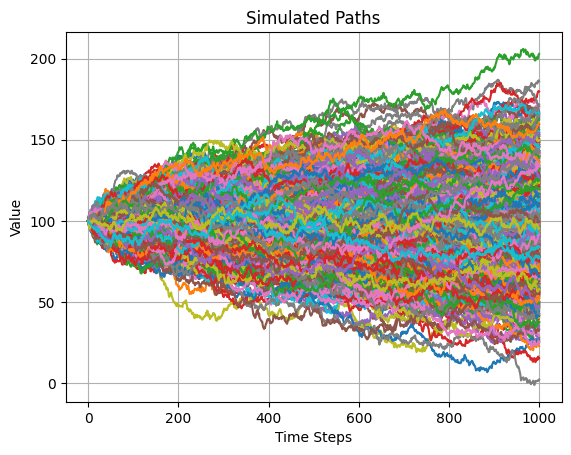

In [65]:
# Simulazione del sottostante
def sottostante(X0, sigma, dt, steps, N):
    # inizializzazione dei valori iniziali
    paths = np.zeros((steps, N))  
    paths[0] = X0
    # Creazione dei paths
    for i in range(1, steps):
        paths[i] = paths[i-1] + sigma * np.sqrt(dt) * np.random.normal(size=N)
    return paths

# Simulare percorsi del sottostante
paths = sottostante(X0, sigma, dt, K, N)

# Plot
plt.plot(paths)
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Simulated Paths')
plt.grid(True)
plt.show()

In [66]:

# Calcolo delle simulazioni dei CVA
cumulative_sum_with_default_prob = np.zeros(N)
CVAsim = np.zeros(N)
for i in range(N):
    for j in range(K-1):
        cumulative_sum_with_default_prob[i] += (np.max(paths[j-1, i]-Str,0) + (np.max(paths[j, i]-Str,0))) / 2 *  probabilities_intervals[j] 
        CVAsim[i]=-lgd*cumulative_sum_with_default_prob[i]

Il valore del CVA è: -0.09376715812020504
Intervallo di confidenza al 98% per il CVA: (-0.1031, -0.0844)


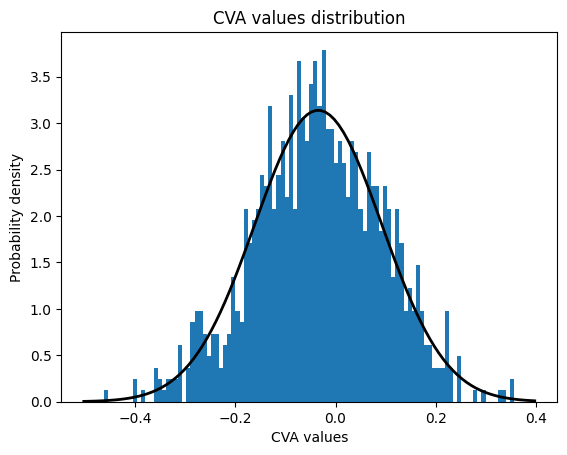

In [67]:
# Media e deviazione standard storica
mean_CVAsim = np.mean(CVAsim)
std_CVAsim = np.std(CVAsim)

# Stima dell'intervallo di confidenza al 98% per il CVA (alpha = 0.01)
alpha = 0.01
z = norm.ppf(alpha)
low = CVA - z * std_CVAsim / np.sqrt(N)
up = CVA + z * std_CVAsim / np.sqrt(N)

print("Il valore del CVA è:", CVA )
print("Intervallo di confidenza al 98% per il CVA: ({:.4f}, {:.4f})".format(up, low))

# Istogramma dei valori raggruppati in 100 gruppi
plt.hist(CVAsim, bins=100, density=True)

# Calcolo della funzione di densità di una normale standard
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean_CVAsim, std_CVAsim)

# Plot
plt.plot(x, p, 'k', linewidth=2)
plt.xlabel('CVA values')
plt.ylabel('Probability density')
plt.title('CVA values distribution')
plt.show()